_Work in progress_

In this post I clean up some data on daily birth numbers in the Netherlands and Belgium. 

* http://statline.cbs.nl/Statweb/publication/?DM=SLNL&PA=70703ned&D1=0&D2=a&HDR=T&STB=G1&VW=D
* http://statbel.fgov.be/nl/statistieken/opendata/datasets/bevolking/

In [1]:
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


* Worden er meer baby's geboren als de economie aantrekt?
* Hoe sterk is de clustering?

In [2]:
daily_ned = pd.read_csv("./data/Bevolkingsontwikkeli_171217121849.csv", encoding="latin-1", delimiter=";").reset_index()
daily_ned.columns = ["datum", "geboortes"]
daily_ned.geboortes = pd.to_numeric(daily_ned.geboortes, errors = "coerce")
daily_ned.head(7)

,datum,geboortes
0,Onderwerpen,NaN
1,Onderwerpen,NaN
2,Perioden,NaN
3,Totaal 1995,190513.0
4,Totaal januari 1995,16436.0
5,Zondag 1 januari 1995,368.0
6,Maandag 2 januari 1995,439.0


In [3]:
daily_ned = daily_ned[~daily_ned.datum.str.lower().str.contains("totaal")].dropna()
daily_ned.geboortes = daily_ned.geboortes.astype(int)

daily_ned.sample(10)

,datum,geboortes
2808,Zondag 14 april 2002,431
7801,2015 maandag 30 maart,482
6429,2011 vrijdag 9 september,522
6321,2011 zaterdag 28 mei,407
5844,Zondag 28-2-2010,378
5933,Dinsdag 25-5-2010,509
4120,Maandag 12 september 2005,567
5299,Zaterdag 4 oktober 2008,447
7416,2014 maandag 31 maart,497
2115,Woensdag 28 juni 2000,573


In [4]:
fmt_yd = daily_ned.datum.str.extract("(?P<year>\d{4}) [a-z]{6,10} (?P<day>\d{1,2}) (?P<month_named>[a-z]{3,11})", expand = True).dropna()
fmt_yd[fmt_yd.any(axis = 1)].sample(5)

,year,day,month_named
6489,2011,6,november
7901,2015,8,juli
7612,2014,13,oktober
6474,2011,23,oktober
6222,2011,21,februari


In [5]:
months = fmt_yd.month_named.dropna().unique()

In [6]:
fmt_yd["month"] = fmt_yd.dropna().month_named.astype('category').cat.reorder_categories(months).cat.codes + 1
fmt_yd.sample(5)

,year,day,month_named,month
6632,2012,17,maart,3
7480,2014,3,juni,6
6653,2012,6,april,4
7168,2013,16,augustus,8
6852,2012,16,oktober,10


In an undocumented feature that I found through [GitHub](https://github.com/nps/pandas/commit/cb7cdaa20ef5af421344819232ee289b93e22e7f), it is possible to combine columns of parts of dates into a datetime64-series. 

In [7]:
yd_dates = pd.to_datetime(fmt_yd.drop('month_named', axis = 1))
yd_dates.sample(5)

7636   2014-11-06
7126   2013-07-05
7123   2013-07-02
7050   2013-04-20
6521   2011-12-07
dtype: datetime64[ns]

In [8]:
fmt_m = daily_ned.datum.str.extract("(?P<day>\d{1,2}) (?P<month_named>[a-z]{3,11}) ?(?P<year>\d{4})", expand = True).dropna()
fmt_m["month"] = fmt_m.month_named.astype('category').cat.reorder_categories(months).cat.codes + 1
m_dates = pd.to_datetime(fmt_m.drop('month_named', axis = 1))

m_dates.sample(5)

2641   2001-11-11
860    1997-03-24
3173   2003-03-26
2510   2001-07-07
3340   2003-09-03
dtype: datetime64[ns]

In [9]:
num_dates = pd.to_datetime(daily_ned.datum, format = "%d-%m-%Y", exact = False, errors = "coerce").dropna()
num_dates.sample(5)

6077   2010-10-11
6018   2010-08-15
5872   2010-03-27
5428   2009-01-30
5931   2010-05-23
Name: datum, dtype: datetime64[ns]

In [10]:
daily_ned = daily_ned.assign(date = pd.concat([yd_dates, m_dates, num_dates]))
daily_ned.sample(5)

,datum,geboortes,date
1003,Zaterdag 9 augustus 1997,479,1997-08-09
7406,2014 vrijdag 21 maart,558,2014-03-21
6625,2012 zaterdag 10 maart,391,2012-03-10
3789,Woensdag 3 november 2004,545,2004-11-03
1469,Dinsdag 27 oktober 1998,575,1998-10-27


In [11]:
daily_ned[daily_ned.date.isnull()]

,datum,geboortes,date
5783,Overig,243,NaT
6553,Overig,171,NaT
6940,Overig,131,NaT
7314,Overig,144,NaT
7700,Overig,229,NaT
8086,Overig,121,NaT


In [12]:
daily_ned.dropna().date.dt.year.value_counts().sort_index().to_frame()

,date
1995,365
1996,366
1997,365
1998,365
1999,365
2000,366
2001,365
2002,365
2003,365
2004,366


Looks good!

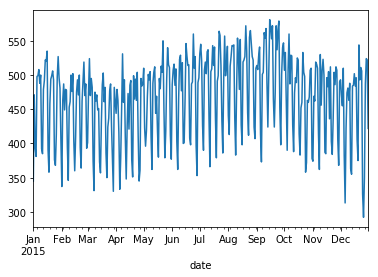

In [22]:
daily_ned[daily_ned.date.dt.year == 2015].set_index('date').geboortes.plot()